In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import time
from skimage.transform import resize, rescale
from PIL import Image

In [2]:
from __future__ import print_function, division
import torch.nn as nn
import torch.nn.functional as F
import torch


def add_block_a(inputs, outputs, s=1):
    return nn.Sequential(
        nn.Conv2d(in_channels=inputs, out_channels=outputs, stride=s, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),

        nn.Conv2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),

        nn.Conv2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),

        nn.Dropout(p=0.1)
    )


def add_block_a_dash(inputs, outputs):
    return nn.Sequential(
        nn.Conv2d(in_channels=inputs, out_channels=outputs, stride=2, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),

        nn.Conv2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1, dilation=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),

        nn.Conv2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1, dilation=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),

        nn.Dropout(p=0.1)
    )


def add_block_a_double_dash(inputs, outputs, d):
    return nn.Sequential(
        nn.Conv2d(in_channels=inputs, out_channels=outputs, kernel_size=3, padding=1, dilation=d),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),

        nn.Conv2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1, dilation=d),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),

        nn.Conv2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1, dilation=d),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),

        nn.Dropout(p=0.1)
    )


def add_block_b(inputs, outputs):
    return nn.Sequential(
        nn.Conv2d(in_channels=inputs, out_channels=outputs, stride=2, kernel_size=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),

        nn.ConvTranspose2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),

        nn.Conv2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),

        nn.Conv2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),

        nn.Dropout(p=0.1)
    )


def add_block_c(inputs, outputs):
    return nn.Sequential(
        nn.Conv2d(in_channels=inputs, out_channels=outputs, stride=2, kernel_size=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),

        nn.ConvTranspose2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),
    )


def add_block_d_or_e(inputs, outputs):
    return nn.Sequential(
        nn.Conv2d(in_channels=inputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),

        nn.Conv2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),

        nn.Conv2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),

        nn.Softmax(dim=1),
    )


def add_block_f(inputs, outputs):
    return nn.Sequential(
        nn.Conv2d(in_channels=inputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),

        nn.Conv2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),

        nn.Conv2d(in_channels=outputs, out_channels=outputs, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(outputs),

        #nn.Linear(in_features=inputs, out_features=outputs),
    )


def concatenate_tensors(tensor1, tensor2):
    diff_height = tensor2.size()[2] - tensor1.size()[2]
    diff_width = tensor2.size()[3] - tensor1.size()[3]

    tensor1 = F.pad(tensor1,
                    [diff_width // 2, diff_width - diff_width // 2, diff_height // 2, diff_height - diff_height // 2])
    return torch.cat([tensor1, tensor2], dim=1)


def shape_as_string(shape):
    return str(list(shape))


class ChargridNetwork(nn.Module):
    def __init__(self, HW, C, num_classes=5, num_anchors=4):
        super(ChargridNetwork, self).__init__()

        '''
        Encoder definition
        '''
        self.first_a_block = add_block_a(HW, C, 1)
        self.second_a_block = add_block_a(C, 2 * C, 2)
        self.a_dash_block = add_block_a_dash(2 * C, 4 * C)
        self.first_a_double_dash_block = add_block_a_double_dash(4 * C, 8 * C, d=2)
        self.second_a_double_dash_block = add_block_a_double_dash(8 * C, 8 * C, d=4)

        '''
        Semantic Segmentation Decoder (ssd)
        '''
        self.ssd_first_b_block = add_block_b(12 * C, 4 * C)
        self.ssd_second_b_block = add_block_b(6 * C, 2 * C)
        self.ssd_c_block = add_block_c(3 * C, C)
        self.ssd_d_block = add_block_d_or_e(C, num_classes)
        self.upsample = nn.Upsample(scale_factor=2)

        '''
        Bounding Box Regression Decoder (bbrd)
        '''

        self.bbrd_first_b_block = add_block_b(12 * C, 4 * C)
        self.bbrd_second_b_block = add_block_b(6 * C, 2 * C)
        self.bbrd_c_block = add_block_c(3 * C, C)
        self.bbrd_e_block = add_block_d_or_e(C, 2*num_anchors)
        self.bbrd_f_block = add_block_f(C, 4*num_anchors)

    def forward(self, x):
        """
        Forward pass function for the network
        :param x:
        :return:
        """

        '''
        Forward pass through Encoder
        '''
        # print("input shape " + shape_as_string(x.shape))

        first_a_block_output = self.first_a_block(x)
        # print("after first a block " + shape_as_string(first_a_block_output.shape))

        second_a_block_output = self.second_a_block(first_a_block_output)
        # print("after second a block " + shape_as_string(second_a_block_output.shape))

        a_dash_block_output = self.a_dash_block(second_a_block_output)
        # print("after a dash block " + shape_as_string(a_dash_block_output.shape))

        first_a_double_dash_block_output = self.first_a_double_dash_block(a_dash_block_output)
        # print("after first a double dash block " + shape_as_string(first_a_double_dash_block_output.shape))

        second_a_double_dash_block_output = self.second_a_double_dash_block(first_a_double_dash_block_output)
        # print("after second a double dash block " + shape_as_string(second_a_double_dash_block_output.shape))

        '''
        Forward pass through semantic segmentation decoder
        '''
        ssd_first_b_block_input = concatenate_tensors(second_a_double_dash_block_output, a_dash_block_output)
        ssd_first_b_block_output = self.ssd_first_b_block(ssd_first_b_block_input)
        # print("ssd after first b block " + shape_as_string(ssd_first_b_block_output.shape))

        ssd_second_b_block_input = concatenate_tensors(ssd_first_b_block_output, second_a_block_output)
        ssd_second_b_block_output = self.ssd_second_b_block(ssd_second_b_block_input)
        # print("ssd after second b block " + shape_as_string(ssd_second_b_block_output.shape))

        ssd_c_block_input = concatenate_tensors(ssd_second_b_block_output, first_a_block_output)
        ssd_c_block_output = self.ssd_c_block(ssd_c_block_input)
        # print("ssd after c block " + shape_as_string(ssd_c_block_output.shape))

        d_block_output = self.ssd_d_block(ssd_c_block_output)
        d_block_output = self.upsample(d_block_output)
        # print("ssd after d block " + shape_as_string(d_block_output.shape))

        '''
        Forward pass through bounding box regression decoder
        '''
        bbrd_first_b_block_input = concatenate_tensors(second_a_double_dash_block_output, a_dash_block_output)
        bbrd_first_b_block_output = self.bbrd_first_b_block(bbrd_first_b_block_input)
        # print("bbrd after first b block " + shape_as_string(bbrd_first_b_block_output.shape))

        bbrd_second_b_block_input = concatenate_tensors(bbrd_first_b_block_output, second_a_block_output)
        bbrd_second_b_block_output = self.bbrd_second_b_block(bbrd_second_b_block_input)
        # print("bbrd after second b block " + shape_as_string(bbrd_second_b_block_output.shape))

        bbrd_c_block_input = concatenate_tensors(bbrd_second_b_block_output, first_a_block_output)
        bbrd_c_block_output = self.bbrd_c_block(bbrd_c_block_input)
        # print("bbrd after c block " + shape_as_string(bbrd_c_block_output.shape))

        bbrd_e_block_output = self.bbrd_e_block(bbrd_c_block_output)
        bbrd_e_block_output = self.upsample(bbrd_e_block_output)
        # print("bbrd after e block " + shape_as_string(bbrd_e_block_output.shape))

        bbrd_f_block_output = self.bbrd_f_block(bbrd_c_block_output)
        bbrd_f_block_output = self.upsample(bbrd_f_block_output)
        # print("bbrd after f block " + shape_as_string(bbrd_f_block_output.shape))

        return d_block_output, bbrd_e_block_output, bbrd_f_block_output

In [3]:
net = ChargridNetwork(3, 64, 5, 4)

In [4]:
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
summary(net, input_size=(3, 256, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 128]           1,792
         LeakyReLU-2         [-1, 64, 256, 128]               0
       BatchNorm2d-3         [-1, 64, 256, 128]             128
            Conv2d-4         [-1, 64, 256, 128]          36,928
         LeakyReLU-5         [-1, 64, 256, 128]               0
       BatchNorm2d-6         [-1, 64, 256, 128]             128
            Conv2d-7         [-1, 64, 256, 128]          36,928
         LeakyReLU-8         [-1, 64, 256, 128]               0
       BatchNorm2d-9         [-1, 64, 256, 128]             128
          Dropout-10         [-1, 64, 256, 128]               0
           Conv2d-11         [-1, 128, 128, 64]          73,856
        LeakyReLU-12         [-1, 128, 128, 64]               0
      BatchNorm2d-13         [-1, 128, 128, 64]             256
           Conv2d-14         [-1, 128, 

In [5]:
net

ChargridNetwork(
  (first_a_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.1, inplace=False)
  )
  (second_a_block): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), pad

In [6]:
net.load_state_dict(torch.load("C:\\Users\\91958\\document_Intelligence\\epoch-0.pt"))

<All keys matched successfully>

In [7]:
net.eval()

ChargridNetwork(
  (first_a_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.1, inplace=False)
  )
  (second_a_block): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), pad

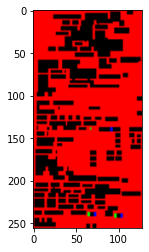

In [8]:
import torchvision
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

img_array = np.load("C:\\Users\\91958\\document_Intelligence\\onehot_chargrid\\017.npy")

image1 = Image.fromarray(np.uint8(np.squeeze(img_array[:, :, 0:3] * 255)))

plt.imshow(image1, cmap='gray')
plt.show()



In [9]:
print(img_array.shape)

(256, 128, 61)


In [10]:
image2 = transforms(image1)

In [11]:
image2.shape

torch.Size([3, 256, 128])

In [12]:
image3 = image2.unsqueeze(0)

In [13]:
print(image3.shape)

torch.Size([1, 3, 256, 128])


In [15]:
output1, output2, output3 = net(image3.cuda())

In [16]:
output1.shape , output2.shape , output3.shape

(torch.Size([1, 5, 256, 128]),
 torch.Size([1, 8, 256, 128]),
 torch.Size([1, 16, 256, 128]))

In [17]:
output1.cpu().data.numpy().argmax()

13622

In [18]:
output2.cpu().data.numpy().argmax()

242752

In [19]:
output3.cpu().data.numpy().argmax()

85046

(5, 256, 128)
(256, 128, 5)


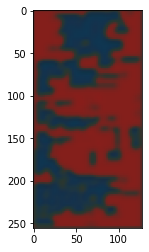

In [20]:
##output1=========================

preds1 = output1.cpu().data.numpy()

pred = np.squeeze(preds1)
print(pred.shape)

b = np.transpose(pred, (1, 2, 0))
print(b.shape)


pred = Image.fromarray(np.uint8(np.squeeze(b[:, :, 0:3] * 255)))

plt.imshow(pred, cmap='gray')
plt.show()


(8, 256, 128)
(256, 128, 8)


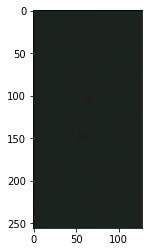

In [22]:
##output2========================

preds2 = output2.cpu().data.numpy()

pred3 = np.squeeze(preds2)
print(pred3.shape)

b1 = np.transpose(pred3, (1, 2, 0))

print(b1.shape)


pred4 = Image.fromarray(np.uint8(np.squeeze(b1[:, :, 0:3] * 255)))

plt.imshow(pred4, cmap='jet')
plt.show()



(8, 256, 128)
(256, 128, 8)


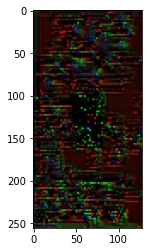

In [144]:
###output3======================
preds5 = output3.cpu().data.numpy()

pred6 = np.squeeze(preds2)
print(pred6.shape)

b2 = np.transpose(pred6, (1, 2, 0))

print(b2.shape)


pred7 = Image.fromarray(np.uint8(np.squeeze(b2[:, :, 0:3] * 255)))


plt.imshow(pred7, cmap='jet')
plt.show()

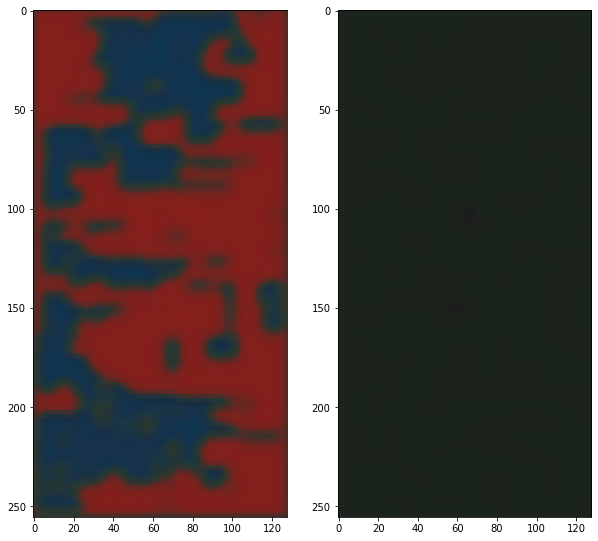

In [24]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(10,10))

####output1 and output2============================


ax1.imshow(pred,cmap='jet')
ax2.imshow(pred4,cmap='jet')

pred.save('segmented.jpg')

In [25]:

### output1============

value, index = torch.max(output1,1)

In [26]:
print(value)

print(value.shape)

tensor([[[0.3255, 0.3255, 0.4191,  ..., 0.4134, 0.3201, 0.3201],
         [0.3255, 0.3255, 0.4191,  ..., 0.4134, 0.3201, 0.3201],
         [0.3678, 0.3678, 0.4853,  ..., 0.4750, 0.3574, 0.3574],
         ...,
         [0.2644, 0.2644, 0.2432,  ..., 0.4666, 0.3519, 0.3519],
         [0.2332, 0.2332, 0.2375,  ..., 0.3044, 0.2559, 0.2559],
         [0.2332, 0.2332, 0.2375,  ..., 0.3044, 0.2559, 0.2559]]],
       device='cuda:0', grad_fn=<MaxBackward0>)
torch.Size([1, 256, 128])


In [27]:
print(index)

print(index.shape)

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0')
torch.Size([1, 256, 128])


In [29]:
value1 = value.detach().cpu().numpy()
print(value1.shape)


(1, 256, 128)


(256, 128, 1)


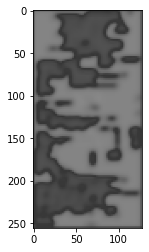

In [30]:
value2 = np.transpose(value1, (1, 2, 0))

print(value2.shape)


value3 = Image.fromarray(np.squeeze(value2[:, :, 0:1] * 255))

plt.imshow(value3, cmap='gray')
plt.show()

In [31]:
### output2======================


value, index = torch.max(output2,1)
value1 = value.detach().cpu().numpy()
print(value1.shape)

(1, 256, 128)


(256, 128, 1)


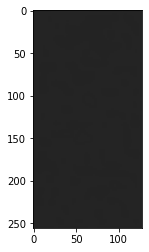

In [33]:
value2 = np.transpose(value1, (1, 2, 0))

print(value2.shape)


value3 = Image.fromarray(np.squeeze(value2[:, :, 0:1] * 255))

plt.imshow(value3, cmap='jet')
plt.show()

(1, 256, 128)
(256, 128, 1)


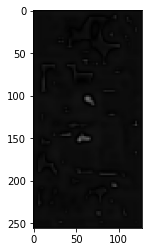

In [35]:
### output3=====================================

value, index = torch.max(output3,1)
value1 = value.detach().cpu().numpy()
print(value1.shape)

value2 = np.transpose(value1, (1, 2, 0))

print(value2.shape)


value3 = Image.fromarray(np.squeeze(value2[:, :, 0:1] * 255))

plt.imshow(value3, cmap='gray')
plt.show()


# Load model 'epoch-1.pt'

In [15]:
checkpoint = torch.load('C:\\Users\\91958\\document_Intelligence\\epoch-1.pt')
net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [16]:
net.eval()

ChargridNetwork(
  (first_a_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Dropout(p=0.1, inplace=False)
  )
  (second_a_block): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), pad

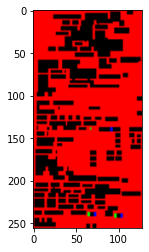

In [17]:
import torchvision
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

img_array = np.load("C:\\Users\\91958\\document_Intelligence\\onehot_chargrid\\017.npy")

image1 = Image.fromarray(np.uint8(np.squeeze(img_array[:, :, 0:3] * 255)))

plt.imshow(image1, cmap='gray')
plt.show()

In [18]:
image2 = transforms(image1)

image3 = image2.unsqueeze(0)

In [20]:
output1, output2, output3 = net(image3.to(device))

In [21]:
output1.shape, output2.shape, output3.shape

(torch.Size([1, 5, 256, 128]),
 torch.Size([1, 8, 256, 128]),
 torch.Size([1, 16, 256, 128]))

(5, 256, 128)
(256, 128, 5)


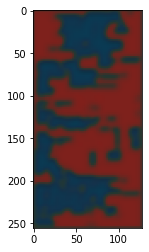

In [22]:
preds1 = output1.cpu().data.numpy()

pred = np.squeeze(preds1)
print(pred.shape)

b = np.transpose(pred, (1, 2, 0))
print(b.shape)


pred = Image.fromarray(np.uint8(np.squeeze(b[:, :, 0:3] * 255)))

plt.imshow(pred, cmap='gray')
plt.show()


(8, 256, 128)
(256, 128, 8)


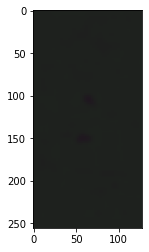

In [24]:
preds2 = output2.cpu().data.numpy()

pred3 = np.squeeze(preds2)
print(pred3.shape)

b1 = np.transpose(pred3, (1, 2, 0))

print(b1.shape)


pred4 = Image.fromarray(np.uint8(np.squeeze(b1[:, :, 0:3] * 255)))

plt.imshow(pred4, cmap='gray')
plt.show()


(8, 256, 128)
(256, 128, 8)


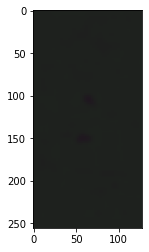

In [25]:
###output3======================
preds5 = output3.cpu().data.numpy()

pred6 = np.squeeze(preds2)
print(pred6.shape)

b2 = np.transpose(pred6, (1, 2, 0))

print(b2.shape)


pred7 = Image.fromarray(np.uint8(np.squeeze(b2[:, :, 0:3] * 255)))


plt.imshow(pred7, cmap='jet')
plt.show()